# Imports and settings

In [20]:
from tqdm import tqdm
import implicit
import bisect
from collections import defaultdict

import pandas as pd
import pyarrow.parquet as pq
import scipy
import numpy as np

from sklearn.metrics import roc_auc_score, classification_report    
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler

# graphics settings
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# fix side for reproducability
seed = 42
np.random.seed(seed)

In [21]:
LOCAL_DATA_PATH = "./data/"
DATA_FILE = "raw/"
TARGET_FILE = "public_train.pqt"
SUBMISSION_FILE = "submit.pqt"

# Baseline approach: als embeddings on user ids, urls and numerical features

**First, read all data and print columns in it. We use parquet format in this part of notebook.**

In [3]:
data = pq.read_table(f"{LOCAL_DATA_PATH}/{DATA_FILE}")
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [["field", "type"]])

,field,type
0,region_name,string
1,city_name,string
2,cpe_manufacturer_name,string
3,cpe_model_name,string
4,url_host,string
5,cpe_type_cd,string
6,cpe_model_os_type,string
7,price,double
8,date,date32[day]
9,part_of_day,string


* Регион   
* Населенный пункт   
* Производиель устройства   
* Модель устроства   
* Домен, с которого пришел рекламный запрос   
* Тип устройства (смартфон или что-то другое)   
* Операционка на устройстве   
* Оценка цены устройства   
* Дата   
* Время дня (утро, вечер ...)   
* Число запросов   
* id пользователя   

**Now do the same thing with target data.**

In [4]:
targets = pq.read_table(f"{LOCAL_DATA_PATH}/{TARGET_FILE}")
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [["field", "type"]])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


**Read also file for submissions.**

In [5]:
id_to_submit = pq.read_table(f"{LOCAL_DATA_PATH}/{SUBMISSION_FILE}").to_pandas()

**Now construct url and user sets and dicts for work with sparse matrices.**

In [6]:
data_agg = data.select(["user_id", "url_host", "price"]).\
    group_by(["user_id", "url_host"]).aggregate([("price", "sum")])

url_set = set(data_agg.select(["url_host"]).to_pandas()["url_host"])
print(f"{len(url_set)} urls")
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(["user_id"]).to_pandas()["user_id"])
print(f"{len(usr_set)} users")
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


**Now make embeggins matrix. We use all numerical features (price, request_cnt) and calculate mean, min, max and sum values of these features with the same user id. Important parameters for us are embedding_dim and num_iterations. In baseline notebook, authors used only request_cnt feature with sum aggregation, and embeddings with 50 dimensions after 30 als training iterations. So, we probably can improve that solution with that simple approach.**

In [7]:
EMBEDDING_DIM = 64
NUM_ITERATION = 32
embs = None
for col in ["price", "request_cnt"]:
    for op in tqdm(["stddev", "mean", "min", "max", "sum"]):
        data_agg = data.select(["user_id", "url_host", col]).group_by(["user_id", "url_host"]).aggregate([(col, op)])
        values = np.array(data_agg.select([f"{col}_{op}"]).to_pandas()[f"{col}_{op}"])
        rows = np.array(data_agg.select(["user_id"]).to_pandas()["user_id"].map(usr_dict))
        cols = np.array(data_agg.select(["url_host"]).to_pandas()["url_host"].map(url_dict))
        mask = ~np.isnan(values)
        values, rows, cols = values[mask], rows[mask], cols[mask]
        mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
        als = implicit.approximate_als.FaissAlternatingLeastSquares(factors=EMBEDDING_DIM, iterations=NUM_ITERATION, use_gpu=False, \
            calculate_training_loss=False, regularization=0.1, random_state=seed)
        als.fit(mat, show_progress=False)
        embs = als.model.user_factors if embs is None else np.concatenate((embs, als.model.user_factors), axis=1)

100%|██████████| 5/5 [43:37<00:00, 523.46s/it]  


In [9]:
print("Embeddings shape:,", embs.shape)

Embeddings shape:, (415317, 640)


**Now make full dataset by merging target values wit our embeddings.**

In [10]:
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(embs)
usr_emb["user_id"] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how="inner", on=["user_id"])
df = df[df["is_male"] != "NA"]
df = df.dropna()
df["is_male"] = df["is_male"].map(int)
df["is_male"].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [92]:
# make train and test splits
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(["user_id", "age", "is_male"], axis = 1), df["is_male"], test_size=0.33, random_state=seed)

In [93]:
# train model and check quality on test set
%%time
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose=False)
print(f"GINI по полу {2 * roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}")

GINI по полу 0.701


In [94]:
# make prediction for submission data
clf.fit(df.drop(["user_id", "age", "is_male"], axis = 1), df["is_male"], verbose=False)
id_to_submit["is_male"] = clf.predict_proba(id_to_submit.merge(usr_emb, how="inner", on=["user_id"]))[:,1]

In [ ]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

# transform age value to its bucket
df["age"] = df["age"].map(age_bucket)
sns.histplot(df["age"], bins=7)
plt.show()

In [97]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(["user_id", "age", "is_male"], axis = 1), df["age"], test_size=0.33, random_state=seed)

In [98]:
%%time
clf.fit(x_train, y_train, verbose = False)
print(classification_report(y_test, clf.predict(x_test), \
                            target_names = ["<18", "18-25","25-34", "35-44", "45-54", "55-65", "65+"]))

              precision    recall  f1-score   support

         <18       0.25      0.00      0.01       349
       18-25       0.51      0.30      0.38     10663
       25-34       0.48      0.63      0.54     28815
       35-44       0.40      0.51      0.45     25791
       45-54       0.36      0.20      0.26     13931
       55-65       0.40      0.21      0.28      7688
         65+       0.42      0.01      0.03      1849

    accuracy                           0.44     89086
   macro avg       0.40      0.27      0.28     89086
weighted avg       0.43      0.44      0.42     89086



In [99]:
clf.fit(df.drop(["user_id", "age", "is_male"], axis=1), df["age"], verbose=False)
id_to_submit["age"] = clf.predict(id_to_submit[["user_id"]].merge(usr_emb, how="inner", on=["user_id"]))

In [101]:
id_to_submit.to_csv("submission.csv", index=False)

**Score: 1,54**

In [4]:
# save embeddings in order to use them with other features later
usr_emb.to_csv("data/embeddings.csv", index=False)

# Add other features: categorial and urls

In [22]:
id_to_submit = pq.read_table(f"{LOCAL_DATA_PATH}/{SUBMISSION_FILE}").to_pandas()
targets = pq.read_table(f"{LOCAL_DATA_PATH}/{TARGET_FILE}").to_pandas()

In [1]:
# read data with pandas by batching
def get_batch(batch_no):
    df = pq.read_table(f"./data/raw/{batch_no}.parquet").to_pandas()
    df.date = pd.to_datetime(df.date)
    return df

def get_data(num_batches: int = 10):
    batches = []
    for i in tqdm(range(1, num_batches + 1)):
        batches.append(get_batch(i))
    data = pd.concat(batches, ignore_index=True)
    return data

In [5]:
%%time
data = get_data()

100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


CPU times: total: 4min 11s
Wall time: 5min 43s


In [6]:
data.columns

Index(['region_name', 'city_name', 'cpe_manufacturer_name', 'cpe_model_name',
       'url_host', 'cpe_type_cd', 'cpe_model_os_type', 'price', 'date',
       'part_of_day', 'request_cnt', 'user_id'],
      dtype='object')

In [7]:
print("Data shape: ", data.shape)

Data shape:  (322899435, 12)


In [8]:
categorical_features = ["date", "region_name", "city_name", "cpe_manufacturer_name", "cpe_model_name", "cpe_type_cd", "cpe_model_os_type", "part_of_day"]

In [9]:
data["date"] = str(data["date"])

In [10]:
# make label encoding for categorical features
for c in tqdm(categorical_features):
    unique_values = list(data[c].unique())
    val_to_ind = {val: unique_values.index(val) for val in unique_values}
    data[c] = data[c].apply(lambda val: val_to_ind[val])

100%|██████████| 8/8 [15:00<00:00, 112.59s/it]


In [ ]:
for c in categorical_features:
    print(c, len(data[c].unique()))

In [11]:
agg = data.groupby("user_id")

In [ ]:
for c in categorical_features:
    print(c, agg[c].nunique().max())

In [12]:
df = pd.DataFrame(agg["user_id"].min())

In [13]:
# calculate various numeric functions for categorical features
for c in tqdm(categorical_features):
    df[f"{c}_mode"] = agg[c].agg(lambda x: pd.Series.mode(x)[0])
    df[f"{c}_mean"] = agg[c].mean()
    df[f"{c}_min"] = agg[c].min()
    df[f"{c}_max"] = agg[c].max()
    df[f"{c}_median"] = agg[c].median()
    df[f"{c}_std"] = agg[c].std()
    df[f"{c}_sum"] = agg[c].sum()

100%|██████████| 8/8 [08:04<00:00, 60.59s/it]


In [19]:
user_to_url_cnt = defaultdict(lambda : defaultdict(int))
for user, url, cnt in tqdm(zip(np.array(data["user_id"]), np.array(data["url_host"]), np.array(data["request_cnt"]))):
    user_to_url_cnt[user][url] += cnt

322899435it [01:50, 2934648.21it/s]


In [20]:
# calculate number of requests to some most popular url hosts for each users
top_urls = data["url_host"].value_counts()[:1024]
for url in tqdm(top_urls.index):
    df[url] = df["user_id"].apply(lambda user_id: user_to_url_cnt[user_id][url])

100%|██████████| 1024/1024 [13:09<00:00,  1.30it/s] 


In [21]:
embs = pd.read_csv("data/embeddings.csv")

In [22]:
df.index = np.array(range(len(set(df["user_id"]))))

In [23]:
print(df.shape)
df = df.merge(embs, how="inner", on=["user_id"])
print(df.shape)

(415317, 1081)
(415317, 1721)


In [24]:
data = df.copy()
data.to_csv("data/all_features.csv", index=False)

In [17]:
df = pd.read_csv("data/all_features.csv")

In [18]:
data = df.copy()

In [23]:
print(df.shape)
df = df.merge(targets, how="inner", on=["user_id"])
print(df.shape)

(415317, 1721)
(270000, 1723)


In [24]:
df = df[df["is_male"] != "NA"]
df = df.dropna()
df["is_male"] = df["is_male"].map(int)
df["is_male"].value_counts()

1    133916
0    127653
Name: is_male, dtype: int64

In [38]:
# make train and test splits
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(["user_id", "age", "is_male"], axis = 1), df["is_male"], test_size=0.33, random_state=seed)
scaler = StandardScaler().fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

In [46]:
# try improve score by catboost
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        task_type="CPU"
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return 2 * roc_auc_score(y_test, model.predict_proba(x_test)[:,1]) - 1

In [48]:
optuna.logging.set_verbosity(True)

sampler = TPESampler(seed=seed)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2023-03-29 13:33:33,937] A new study created in memory with name: catboost
[I 2023-03-29 13:34:02,175] Trial 0 finished with value: 0.7274687291846935 and parameters: {'iterations': 437, 'learning_rate': 0.07969454818643935, 'depth': 9, 'l2_leaf_reg': 0.00969582664451522, 'bootstrap_type': 'Bayesian', 'random_strength': 2.5361081166471375e-07, 'bagging_temperature': 1.5599452033620265, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 0 with value: 0.7274687291846935.
[I 2023-03-29 13:35:20,977] Trial 1 finished with value: 0.587526547236561 and parameters: {'iterations': 737, 'learning_rate': 0.0010994335574766201, 'depth': 10, 'l2_leaf_reg': 2.1106995036049625, 'bootstrap_type': 'Bayesian', 'random_strength': 8.148018307012941e-07, 'bagging_temperature': 1.8182496720710062, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 0 with value: 0.7274687291846935.
[I 2023-03-29 13:35:43,267] Trial 2 finished with value: 0.6252448912346931 and parameters: {'iterations': 489, 'learning_rate':

In [ ]:
# train model and check quality on test set
clf = Pipeline(steps=[
    ("model", CatBoostClassifier(task_type="CPU"))
])
clf.fit(x_train, y_train)
print(f"GINI по полу {2 * roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}")

In [ ]:
# make prediction for submission data
clf.fit(df.drop(["user_id", "age", "is_male"], axis = 1), df["is_male"])
id_to_submit["is_male"] = clf.predict_proba(id_to_submit.merge(data, how="inner", on=["user_id"]))[:,1]

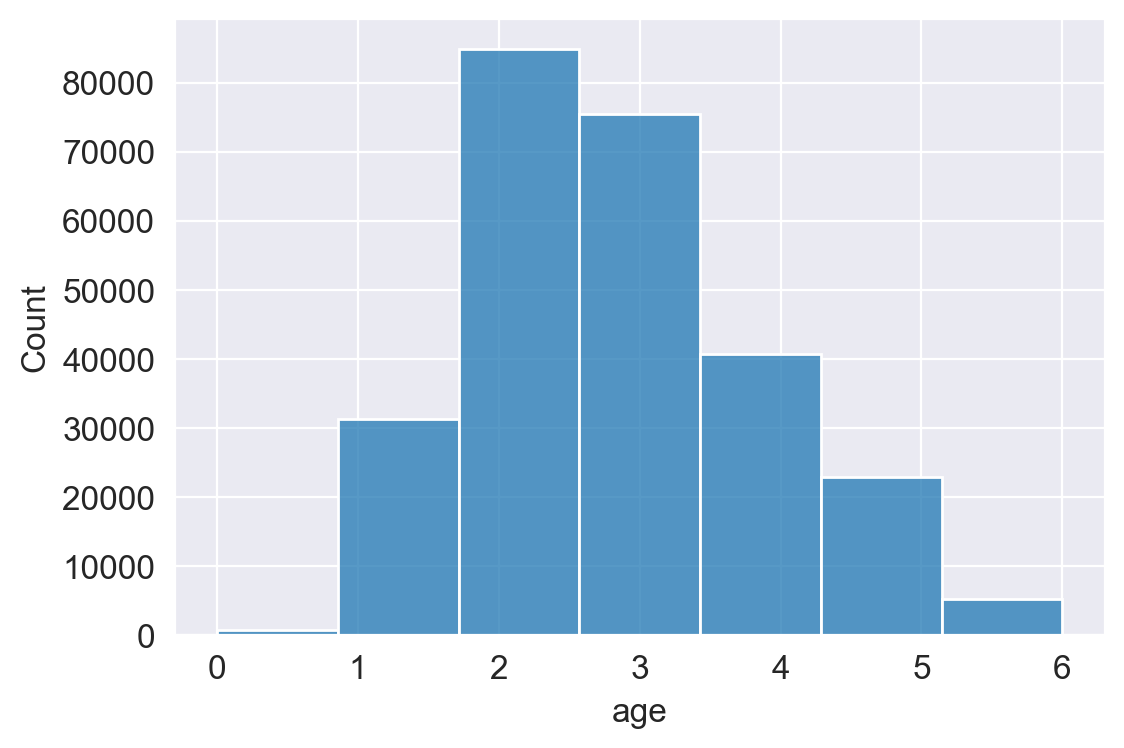

In [16]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

# transform age value to its bucket
df["age"] = df["age"].map(age_bucket)
sns.histplot(df["age"], bins=7)
plt.show()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(["user_id", "age", "is_male"], axis = 1), df["age"], test_size=0.33, random_state=seed)

In [ ]:
clf.fit(x_train, y_train)
print(classification_report(y_test, clf.predict(x_test), \
                            target_names = ["<18", "18-25","25-34", "35-44", "45-54", "55-65", "65+"]))

In [18]:
clf.fit(df.drop(["user_id", "age", "is_male"], axis=1), df["age"])
id_to_submit["age"] = clf.predict(id_to_submit[["user_id"]].merge(data, how="inner", on=["user_id"]))

Learning rate set to 0.105104
0:	learn: 1.8565880	total: 2.31s	remaining: 38m 30s
1:	learn: 1.7850154	total: 4.87s	remaining: 40m 29s
2:	learn: 1.7286255	total: 7.27s	remaining: 40m 16s
3:	learn: 1.6840798	total: 10s	remaining: 41m 34s
4:	learn: 1.6446577	total: 13s	remaining: 43m 9s
5:	learn: 1.6125497	total: 16s	remaining: 44m 18s
6:	learn: 1.5843166	total: 18.4s	remaining: 43m 33s
7:	learn: 1.5607687	total: 21.4s	remaining: 44m 9s
8:	learn: 1.5399171	total: 24s	remaining: 44m 5s
9:	learn: 1.5221281	total: 27.3s	remaining: 45m 7s
10:	learn: 1.5067034	total: 30.1s	remaining: 45m 9s
11:	learn: 1.4928839	total: 32.8s	remaining: 45m 3s
12:	learn: 1.4805639	total: 35.2s	remaining: 44m 29s
13:	learn: 1.4687599	total: 37.5s	remaining: 44m 1s
14:	learn: 1.4585398	total: 40.7s	remaining: 44m 31s
15:	learn: 1.4492104	total: 43.4s	remaining: 44m 31s
16:	learn: 1.4415649	total: 45.9s	remaining: 44m 13s
17:	learn: 1.4345842	total: 48.4s	remaining: 43m 57s
18:	learn: 1.4279601	total: 50.7s	remaini

In [ ]:
id_to_submit.to_csv("submission.csv", index=False)

**Score: 1.64**